# Time Series Forecasting with ARIMA
Christopher Salim, 2019

Modified from https://github.com/lxu213/arima-forecasting

In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pyplot import figure

%matplotlib inline

### Loading data menggunakan library Pandas. Gunakan fungsi head untuk mengecek apakah data sudah terbaca dengan sempurna di Python (5 data pertama).

In [8]:
data = pd.read_excel('./data.xlsx', index_col=0) 
data.head()

,dengue fever (Jawa Timur),Dbd (Jawa Timur),demam berdarah (Jawa Timur),DATA
Tanggal Pencatatan,,,,
2014-09-28,36,4,14,54
2014-10-05,36,4,16,56
2014-10-12,35,4,10,49
2014-10-19,35,7,14,56
2014-10-26,35,7,16,58


In [9]:
# mengecek tipe data.
print(data.shape)
print(data.dtypes)
data.index = pd.to_datetime(data.index, format='%Y/%m/%d')
data.index[161]
data.index[260]

(261, 4)
dengue fever (Jawa Timur)      int64
Dbd (Jawa Timur)               int64
demam berdarah (Jawa Timur)    int64
DATA                           int64
dtype: object


Timestamp('2019-09-22 00:00:00')

In [10]:
# apakah ada NaN value?
data.isnull().values.any()

False

### Exploratory Data Analysis (plotting awal data untuk melihat tren data, outlier, dan lain-lain).

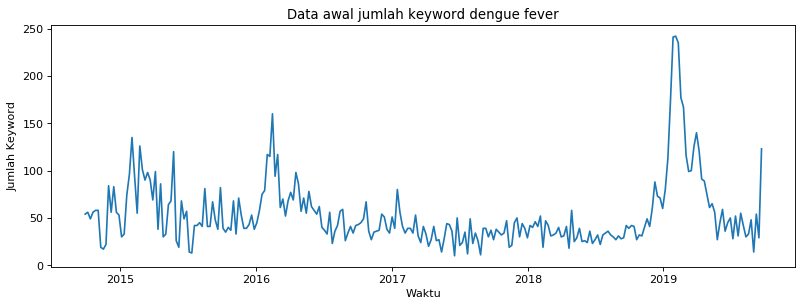

In [14]:
figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
ax.set_xlabel('Waktu')
ax.set_ylabel('Jumlah Keyword')
plt.title('Data awal jumlah keyword dengue fever')
plt.plot(data['DATA']);     

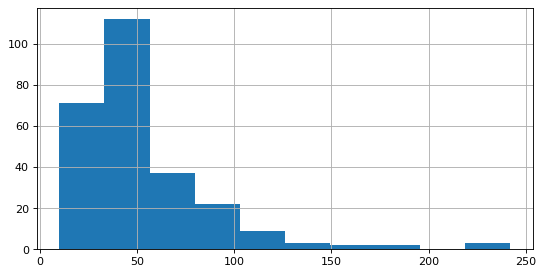

In [16]:
figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
data['DATA'].hist()
plt.show()

## Forecasting

Proses selanjutnya adalah melakukan fitting dan forecasting dengan model ARIMA.

Sebelum membuat model, perlu dipastikan terlebih dahulu bahwa data sudah stasioner terhadap mean maupun variance. Uji stasioner yang akan digunakan adalah test ADF (Augmented Dickey-Fuller test).

Uji ADF menguji hipotesis nol bahwa data time series tidak stasioner dan tergantung pada waktu (H0). Hipotesis alternatif berarti hipotesis nol ditolak, dan berarti data sudah stasioner. Untuk dapat menolak hipotesis nol, diperlukan p-value <= 0.05. Jika p-value masih di atas 0.05 dan nilai test statistic lebih kecil dari critical value, perlu dilakukan differencing agar data menjadi stasioner.

### Uji stasioneritas

In [20]:
# fungsi dengan menggunakan library statsmodel untuk menguji stasioneritas.
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [37]:
dat = data['DATA']
split = int((len(dat) + 1) / 2)
print(split)
X1 = data['DATA'][0:split]
X2 = data['DATA'][split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

131
mean1=56.213740, mean2=50.800000
variance1=697.353964, variance2=1820.610853


Terlihat bahwa data sangat tidak stasioner terhadap variance ketika dibandingkan antara bagian pertama dan kedua data. Hal yang bisa dilakukan adalah melakukan transformasi Box-Cox.

In [27]:
test_stationarity(data['DATA'])

Test Statistic           -3.968528
p-value                   0.001585
Lags                      1.000000
Observations            259.000000
Critical Value (1%)      -3.455853
Critical Value (5%)      -2.872765
Critical Value (10%)     -2.572752
dtype: float64


# Differencing untuk membuat data stasioner terhadap mean
Nilai test statistics sudah lebih kecil dari critical value dan p value < 0.05 sehingga hipotesis nol dapat ditolak. Data sudah stasioner terhadap mean sehingga tidak perlu dilakukan differencing

Jadi, d yang digunakan = 0

## Box-Cox Transformation
Tujuan dari box-cox transformation untuk membuat data juga stasioner terhadap variance. 

-0.1759493903882967


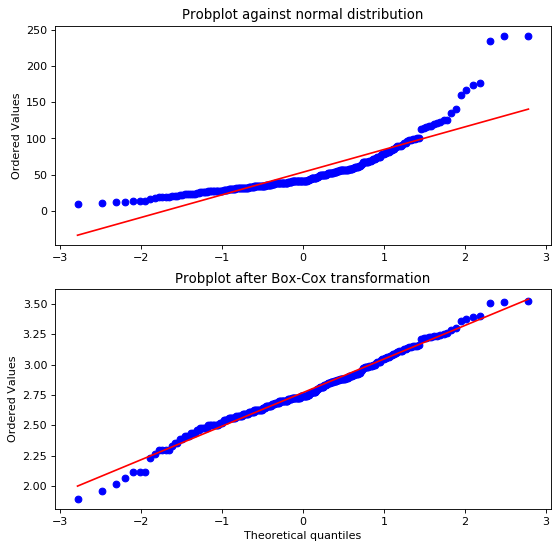

In [50]:
from scipy import stats

fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(211)
stats.probplot(data['DATA'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
data['box'], lam = stats.boxcox(data['DATA'])
stats.probplot(data['box'], dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
print(lam)


### ACF and PACF Graphs
Untuk mengetahui nilai p dan q

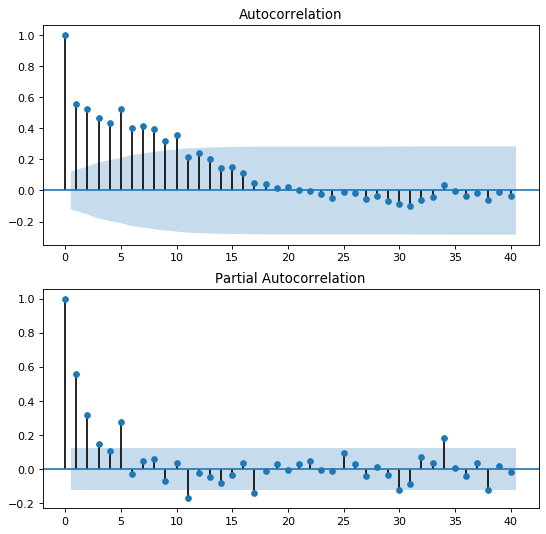

In [51]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['box'][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['box'][1:], lags=40, ax=ax2)

Karena penurunan ACF lebih lambat dan PACF cutoff, maka digunakan model AR.

In [59]:
data_train = data[0:160]
data_test = data[161:260]
data_train.index = pd.to_datetime(data_train.index, format='%Y/%m/%d')
data_test.index = pd.to_datetime(data_test.index, format='%Y/%m/%d')
print(data_train)

                    dengue fever (Jawa Timur)  Dbd (Jawa Timur)  \
Tanggal Pencatatan                                                
2014-09-28                                 36                 4   
2014-10-05                                 36                 4   
2014-10-12                                 35                 4   
2014-10-19                                 35                 7   
2014-10-26                                 35                 7   
2014-11-02                                 36                 7   
2014-11-09                                  0                 5   
2014-11-16                                  0                 3   
2014-11-23                                  0                10   
2014-11-30                                 67                 4   
2014-12-07                                 34                 8   
2014-12-14                                 53                11   
2014-12-21                                 37                 

In [60]:
data_train['DATA.float'] = data_train['box'].astype(float)
data_test['DATA.float'] = data_test['box'].astype(float)
# convert int to float for ARIMA model input
# TODO: do this in a cleaner way
print(data_train['DATA.float'])

Tanggal Pencatatan
2014-09-28    2.866376
2014-10-05    2.884345
2014-10-12    2.817802
2014-10-19    2.884345
2014-10-26    2.901574
2014-11-02    2.901574
2014-11-09    2.298003
2014-11-16    2.231097
2014-11-23    2.384213
2014-11-30    3.077080
2014-12-07    2.884345
2014-12-14    3.071582
2014-12-21    2.884345
2014-12-28    2.857096
2015-01-04    2.559434
2015-01-11    2.611386
2015-01-18    3.018300
2015-01-25    3.137602
2015-02-01    3.285827
2015-02-08    3.128154
2015-02-15    2.875457
2015-02-22    3.256544
2015-03-01    3.160244
2015-03-08    3.108528
2015-03-15    3.146822
2015-03-22    3.108528
2015-03-29    2.985292
2015-04-05    3.151349
2015-04-12    2.686704
2015-04-19    3.087849
                ...   
2017-03-26    2.726503
2017-04-02    2.611386
2017-04-09    2.328419
2017-04-16    2.500980
2017-04-23    2.726503
2017-04-30    2.479777
2017-05-07    2.500980
2017-05-14    2.111121
2017-05-21    2.521279
2017-05-28    2.763016
2017-06-04    2.751179
2017-06-11    2

/home/christophersalim_/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/christophersalim_/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [61]:
print(type(data_train['DATA.float'][5]))

<class 'numpy.float64'>


### Fitting Model

/home/christophersalim_/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/christophersalim_/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.DATA.float   No. Observations:                  159
Model:                 ARIMA(3, 1, 0)   Log Likelihood                   2.017
Method:                       css-mle   S.D. of innovations              0.239
Date:                Thu, 14 Nov 2019   AIC                              5.965
Time:                        20:10:22   BIC                             21.310
Sample:                    10-05-2014   HQIC                            12.196
                         - 10-15-2017                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0015      0.009     -0.161      0.872      -0.019       0.016
ar.L1.D.DATA.float    -0.5572      0.078     -7.188      0.000      -0.709      -0.405
ar.L2.D.DATA.float  

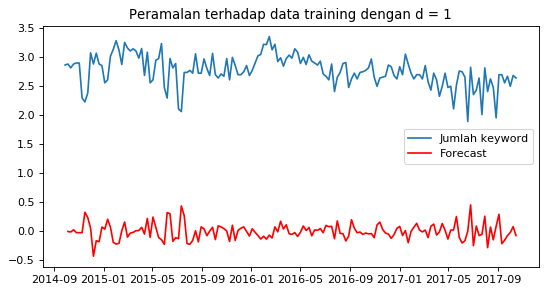

In [70]:
# pembuatan awal ARIMA model
fig = plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
model = ARIMA(data_train['DATA.float'], order=(3,1,0)) 
ax = plt.gca()
results = model.fit()
plt.plot(data_train['box'])
plt.plot(results.fittedvalues, color='red')
plt.title('Peramalan terhadap data training dengan d = 1')
ax.legend(['Jumlah keyword', 'Forecast'])

print(results.summary())

/home/christophersalim_/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:             DATA.float   No. Observations:                  160
Model:                     ARMA(3, 0)   Log Likelihood                   8.484
Method:                       css-mle   S.D. of innovations              0.229
Date:                Thu, 14 Nov 2019   AIC                             -6.968
Time:                        20:11:07   BIC                              8.408
Sample:                    09-28-2014   HQIC                            -0.724
                         - 10-15-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.7680      0.046     60.554      0.000       2.678       2.858
ar.L1.DATA.float     0.3501      0.078      4.471      0.000       0.197       0.504
ar.L2.DATA.float     0.1584 

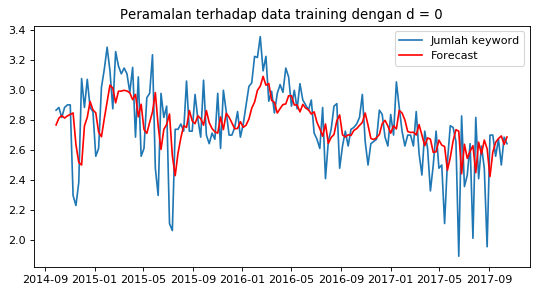

In [71]:
# fit ARIMA model yang tidak menggunakan differencing
fig = plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
model_1 = ARIMA(data_train['DATA.float'], order=(3,0,0)) 
ax_1 = plt.gca()
results_1 = model_1.fit() 
plt.plot(data_train['box'])
plt.plot(results_1.fittedvalues, color='red')
ax_1.legend(['Jumlah keyword', 'Forecast'])
plt.title('Peramalan terhadap data training dengan d = 0')

print(results_1.summary())

### Forecasting Model

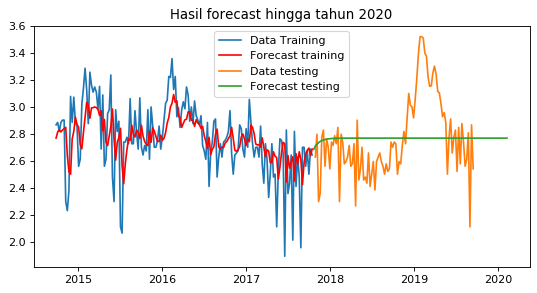

In [79]:
fig = plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
x = results_1.predict(start=(160), end=(280), dynamic=True)
plt.plot(data_train['box'])
plt.plot(results_1.fittedvalues, color='red')
plt.plot(data_test['box'])
plt.title('Hasil forecast hingga tahun 2020')
plt.plot(x)
plt.legend(['Data Training', 'Forecast training', 'Data testing', 'Forecast testing'])

## Menghitung error (MSE, MAPE, MAD)

In [86]:
def err(y_cal, y_true):
    error = y_cal - y_true
    return error

def square_error(error):
    sq_err = error ** 2
    return sq_err

def mse(y_cal, y_true):
    error = err(y_cal, y_true)
    sq_err = square_error(error)
    mse = np.mean(sq_err)
    return mse

def mad(y_cal, y_true):
    error = err(y_cal, y_true)
    ad = np.abs(error)
    mad = np.mean(ad) 
    return mad
def mape(y_cal,y_true):
    error = err(y_cal, y_true)
    ad = np.abs(error)
    ape = ad*100/y_true
    mape = np.mean(ape)
    return mape

mse_train = mse(data_train['box'], results_1.fittedvalues)
mse_test = mse(data_test['box'], x)

mad_train = mad(data_train['box'], results_1.fittedvalues)
mad_test = mad(data_test['box'], x)

mape_train = mape(data_train['box'], results_1.fittedvalues)
mape_test = mape(data_test['box'], x)

print('MSE for train data is = ' + str(mse_train) + ' while MSE for test and forecast is= ' + str(mse_test))
print('MAD for train data is = ' + str(mad_train) + ' while MAD for test and forecast is= ' + str(mad_test))
print('MAPE for train data is = ' + str(mape_train) + ' while MAPE for test and forecast is= ' + str(mape_test))


MSE for train data is = 0.05256125030567236 while MSE for test and forecast is= 0.08322134179285064
MAD for train data is = 0.17238239286831297 while MAD for test and forecast is= 0.22360292421282038
MAPE for train data is = 6.276908084743873 while MAPE for test and forecast is= 8.08314487922335


## Kesimpulan
Model ARIMA(3,0,0) kali ini hanya dapat memprediksi hasil peramalan secara general (secara nilai mean). Jika terdapat lebih banyak data untuk dipelajari, dapat digunakan model yang lebih kompleks untuk dapat meramalkan secara lebih detail.